
# Variance Reduction Demo

This notebook demonstrates shows the effectiveness of variance reduction. We compare two acquisition functions: `RolloutEI`, which doesn't use variance reduction, with `RolloutEI_VR`, which does use variance reduction. 

In [1]:
# Basic import statements
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Lookahead import statements
from lookahead.acquisitions.rollout_ei import RolloutEI
from lookahead.acquisitions.rollout_ei_vr import RolloutEI_VR
from lookahead.model.gaussian_process import GaussianProcessSimple as GP
from lookahead.model.domain import ClosedInterval, TensorProductDomain
opt_domain = TensorProductDomain([ClosedInterval(0, 1)])

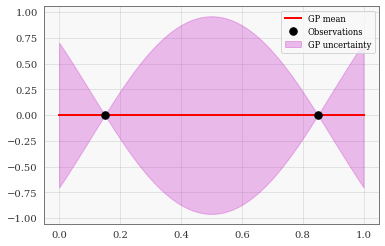

In [2]:
fig, ax = plt.subplots(1, 1)
xtrain = np.linspace(0.15, 0.85, 2)[:, None]
ytrain = np.array([0, 0])
gp = GP(xtrain, ytrain)
gp.set_hypers([5, 0.25])
x = np.linspace(0, 1, 100)[:, None]
y_gp = gp.mean(x)
y_var = np.sqrt(gp.variance(x))
_ = ax.plot(x, y_gp, color='r')
_ = ax.plot(xtrain, ytrain, 'k.', markersize=15)
_ = ax.fill_between(x[:, 0], y_gp - y_var, y_gp + y_var, color='m', alpha=0.25)
_ = ax.legend(['GP mean','Observations','GP uncertainty'])

# Visual Comparison

Below, we compute rollout of EI for horizon to (EI2) without and with variance reduction, in the left and right plots, respectively. The code is meant to be fast, and so for illustrative purposes we only use 20 MC samples. On the left, you can clearly that standard MC is too noisy to be useful. On the right, a combination of quasi-Monte Carlo and control variances let us compute EI2 to a high degree of accuracy. 

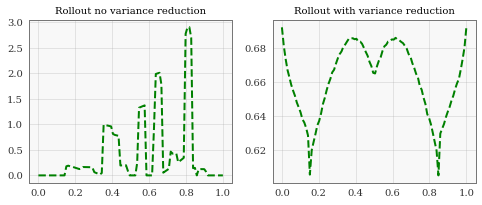

In [9]:
(fig, ax) = plt.subplots(1, 2, figsize=(8, 3))
ei2 = RolloutEI(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=20)
ei2_vals = ei2.evaluate_at_point_list(x)

ei2 = RolloutEI_VR(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=20)
ei2_vals_vr = ei2.evaluate_at_point_list(x)

_ = ax[0].plot(x, ei2_vals, '--g')
_ = ax[1].plot(x, ei2_vals_vr, '--g')
_ = ax[0].set_title('Rollout no variance reduction')
_ = ax[1].set_title('Rollout with variance reduction')

# Comparing estimator accuracy

Below, we compare the accuracy of the Monte Carlo with and without variance reduction in a more precise way. We compute the value of a single point in the above acquisition function, and plot accuracy vs MC samples. We assume the baseline uses 1000 MC iterations with variance reduction. As you can see, variance reduction reduces the error by at least an order of magnitude; this saves at least two orders of magnitude in compute time! 

Note that for the sake of fast plotting, we only run a few trials of each estimator, which we believe to be sufficient to illustrate our point. In practice, one would average across many trials to get a better estimate of estimation error. 

In [6]:
# Compute baseline
xtest = np.array([[0.0]])
ei2 = RolloutEI_VR(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=1000)
baseline_value = ei2.evaluate_at_point_list(xtest)[0]

# Compute errors for different MC iters
mc_iters_all = [8, 16, 32, 64, 128, 256, 512]
errors_mc = []
errors_mc_vr = []
num_trials = 3
for mc_iters in mc_iters_all:
    error = 0
    error_vr = 0
    for i in range(num_trials):
        ei2 = RolloutEI(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=mc_iters)
        ei2_vr = RolloutEI_VR(gp, opt_domain, horizon=2, opt_mode='grid', mc_iters=mc_iters, seed=i)
        error += np.abs(ei2.evaluate_at_point_list(xtest)[0] - baseline_value)
        error_vr += np.abs(ei2_vr.evaluate_at_point_list(xtest)[0] - baseline_value)
    errors_mc.append(error)
    errors_mc_vr.append(error_vr)

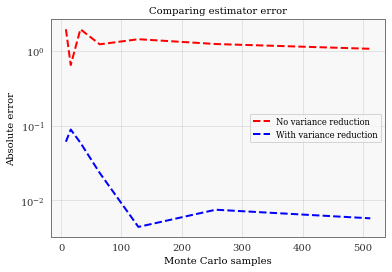

In [8]:
# Plot, in loglog, the absolute errors
_ = plt.semilogy(mc_iters_all, errors_mc, '--r')
_ = plt.semilogy(mc_iters_all, errors_mc_vr, '--b')
_ = plt.legend(['No variance reduction','With variance reduction'])
_ = plt.xlabel('Monte Carlo samples')
_ = plt.ylabel('Absolute error')
_ = plt.title('Comparing estimator error')